---
# [pRFmodelFitter](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.pRFmodelFitting)

This page shows how I implement `pRF`-fitting routines on the back of [prfpy](https://github.com/VU-Cog-Sci/prfpy). You can quite easily fit data, save data, and load data back in. It also has quick visualizations to check certain characteristics of your pRF (e.g., location in visual space, it's raw timecourse, and the prediction given a model)

In [1]:
from fmriproc import prf
from lazyfmri import plotting
import numpy as np
import os
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
opd = os.path.dirname
opj = os.path.join

In [2]:
# first we'll load some data (I provided a npy-file in the fMRIproc repo)
data = np.load(opj(opd(prf.__file__), 'examples', 'prf.npy'))
data.shape

(221,)

The timecourse normally has 225 timepoints (standard for our pRF-acquisitions) and concerns 1 voxel, but we have cut the first 4 volumes to account for scanner stabilization. We can easily plot this timecourse with [LazyLine](https://linescanning.readthedocs.io/en/latest/classes/plotting.html#linescanning.plotting.LazyPlot). We can also add some customization to make the timecourse look prettier

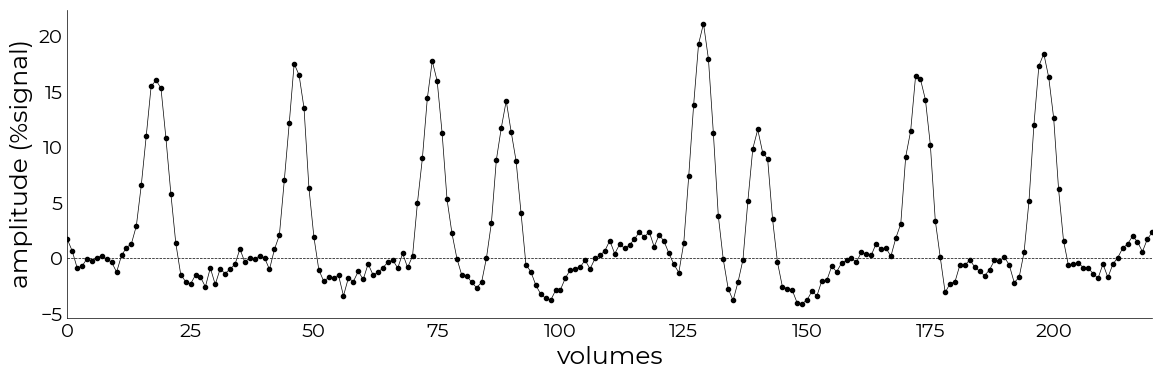

In [48]:
%matplotlib inline
plotting.LazyLine(
    data,
    add_hline="default",            # adds horizontal line at y=0
    color='k',                      # sets color of plot
    line_width=0.5,                   # line thickness
    x_label="volumes",              # x label
    y_label="amplitude (%signal)",  # y label
    markers='.'
)

To know when the stimulus was at a given time point, we need the design matrix: a binarized representation of what happened on the screen. If you have a regular acquisition, you can use [get_prfdesign](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.get_prfdesign) to create your design matrix. For now, let's load in the matrix we have in the repository

In [12]:
# we have a .mat file, which we can load in with scipy.io.loadmat
design = io.loadmat(opj(opd(prf.__file__), 'examples', 'design_task-2R.mat'))
design

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Jul 27 12:05:39 2022',
 '__version__': '1.0',
 '__globals__': [],
 'stim': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.,

In [14]:
# As you can see, this is a dictionary. Not a numpy array. We can get the numpy array by selecting the `stim` attribute
design = design['stim']
print(design.shape)

# if you're not sure what the key is to find the design matrix, you can parse all the keys in the dictionary and select the last one
dm_fn = opj(opd(prf.__file__), 'examples', 'design_task-2R.mat')
design = io.loadmat(dm_fn)
key_list = list(design.keys())
print(key_list)

(100, 100, 225)
['__header__', '__version__', '__globals__', 'stim']


In [15]:
# now select the last item with -1
design = design[key_list[-1]]
design.shape

(100, 100, 225)

To make life easier, there's a function [read_par_file](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.read_par_file) than can do this for you

In [17]:
design = prf.read_par_file(dm_fn)
design.shape

(100, 100, 225)

This particular design is now a representation of the screen, but downsampled to 100x100 pixels (rather than 1920x1080) to reduce processing time. Note that the shape of the design matrix is automatically matched to the time course.

A pRF-fit generally consists of two stages: a fast search (`grid`-fit) in which initial parameters for the model are found and a second, slower (`iterative`-fit), in which we iterate over the parameters to find the optimal set. Let's fit a simple `Gaussian` model.

In [18]:
# the data must be <voxels,time>, but above we have <time,voxels>. We therefore need to transpose our array
gauss = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    fit_hrf=False,
    constraints="nelder",
    TR=1.5,                     # default
    model="gauss",              # default, can be 'gauss', 'css', 'dog', 'norm'
    stage="iter",               # default
    verbose=True,               # keep track of what we're doing,
    fix_bold_baseline=True      # fix the BOLD baseline at 0,
)

Design has 4 more volumes than timecourses, trimming from beginning of design to (100, 100, 221)
Reading settings from '/Users/heij/miniconda3/lib/python3.9/site-packages/fmriproc/misc/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=False)
Using constraint(s): ['nelder', 'nelder'] (gauss | extended)


The stuff above just initializes everything, rather than actually fitting it. This is so we can also load existing parameters without fitting. But, for now, let's fit. We'll get back to the loading later. The settings used for the grids and stuff are specified in the default [settings file](https://github.com/gjheij/linescanning/blob/main/misc/prf_analysis.yml). Change this to your liking, but generally the defaults are fine and in compliance with Marco Aqil's fitting procedures.


In [19]:
# fit
gauss.fit()

Starting Gaussian gridfit (1, 221) at 2025/03/03 18:53:15
Each batch contains approx. 1 voxels.
Completed Gaussian gridfit at 2025/03/03 18:53:29. Voxels/vertices above 0.1: 1/1
Gridfit took 0:00:13.514390 | Mean rsq>0.1: 0.76
Starting Gaussian iterfit (1, 221) at 2025/03/03 18:53:29
Completed Gaussian iterfit at 2025/03/03 18:53:35. Mean rsq>0.1: 0.76
Iterfit took 0:00:06.743964


With [plot_vox](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.pRFmodelFitting.plot_vox) (a function inside the `prf.pRFmodelFitting`-object; in this case `gauss`), we can quickly visualize the pRF-location, the timecourse, and the predicted timecourse for a given `vox_nr` (especially useful if you have 2D data). It will return a tuple containing the following: 

- The pRF estimates
- The pRF in visual field
- The actual BOLD timecourse
- The prediction

If you just want to see the timecourse and prf, use `_,_,_,_` to silence the output. The function relies on [LazyPlot](https://linescanning.readthedocs.io/en/latest/classes/plotting.html#linescanning.plotting.LazyPlot) and [LazyPRF](https://linescanning.readthedocs.io/en/latest/classes/plotting.html#linescanning.plotting.LazyPRF), so you can add the same level of customization as before, though `plot_vox` has some stuff set to default for you.

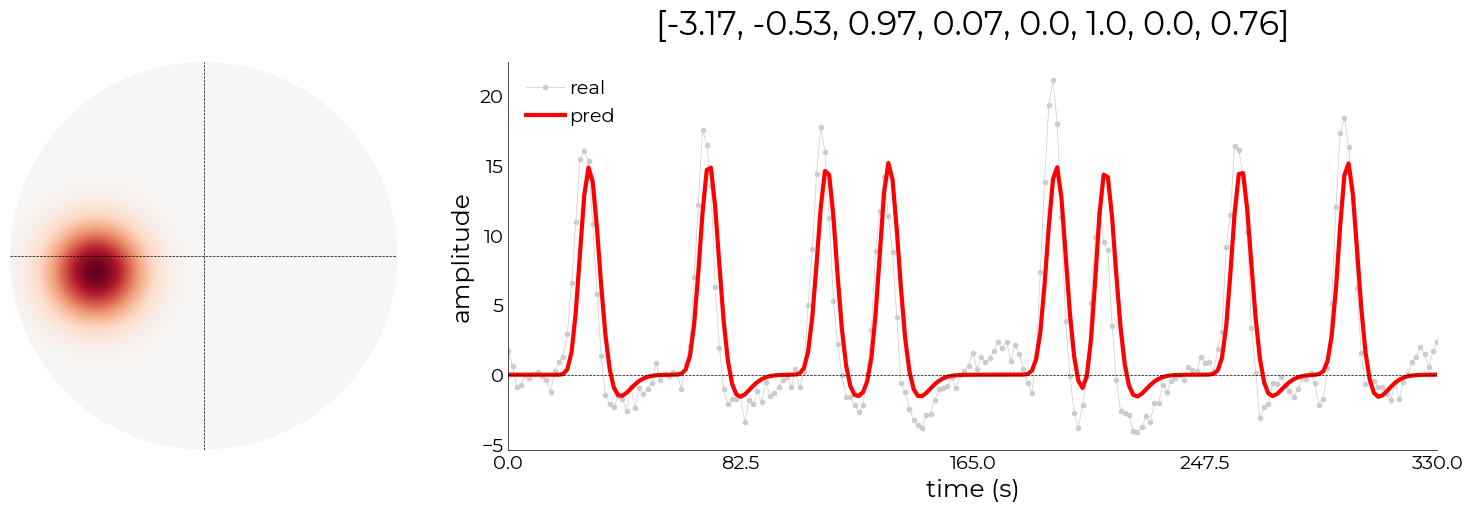

In [20]:
# plot the model fit
_,_,_,pred1 = gauss.plot_vox(
    vox_nr=0, 
    title="pars",
    axis_type="time"
)

With this model, we have a variance explained of `0.76` (or 76%) percent. We can see that the baseline is indeed fixed at 0, and that the peaks generally follow the stimulation period. We can improve this by using models that capture different kinds of characteristics, such as compression (`CSS`), surround suppression (`DoG`), or both (`Divisive Normalization` [DN])

In [24]:
# switching models is very easy. Every model that is NOT Gaussian will build on the Gaussian parameters. So, everytime your run such a model, it will re-fit the Gaussian parameters first. To avoid this, you can either specify the Gaussian fitter object (`gauss`) above as `previous_gaussian_fitter`-argument, or a numpy array as `old_params`-argument (which will create the `previous_gaussian_fitter` inside of the new object). Both options will make sure the Gaussian stage is skipped

# insert old parameters 
norm = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,
    model="norm",
    verbose=True,
    fix_bold_baseline=True,
    old_params=gauss.gauss_iter, # less explicit
    )

norm = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,
    model="norm",
    verbose=True,
    fix_bold_baseline=True,
    constraints="tc",
    previous_gaussian_fitter=gauss.gaussian_fitter,  # very explicit
    )

# and fit
norm.fit()

Design has 4 more volumes than timecourses, trimming from beginning of design to (100, 100, 221)
Reading settings from '/Users/heij/miniconda3/lib/python3.9/site-packages/fmriproc/misc/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc'] (gauss | extended)
Design has 4 more volumes than timecourses, trimming from beginning of design to (100, 100, 221)
Reading settings from '/Users/heij/miniconda3/lib/python3.9/site-packages/fmriproc/misc/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.9s


Completed norm iterfit at 2025/03/03 18:58:20. Mean rsq>0.1: 0.93
Iterfit took 0:03:05.029901


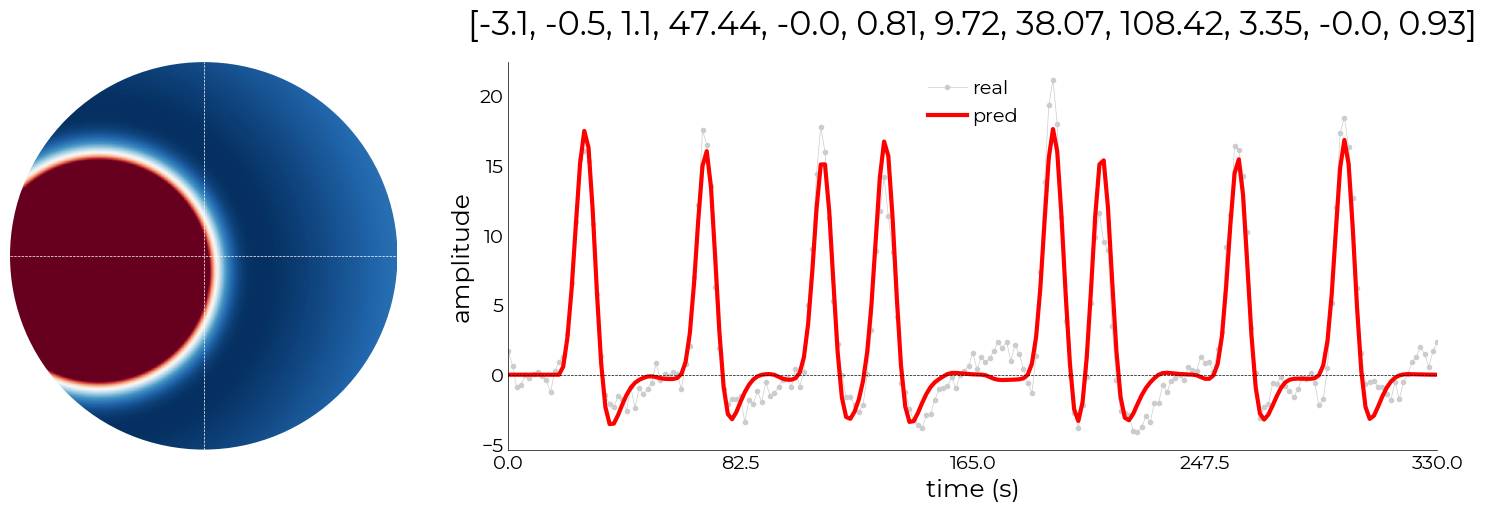

In [26]:
# plot the model fit
_,_,_,pred2 = norm.plot_vox(
    vox_nr=0, 
    title="pars", 
    model="norm")

This has improved the model fit marginally. We can plot the fits together as follows:

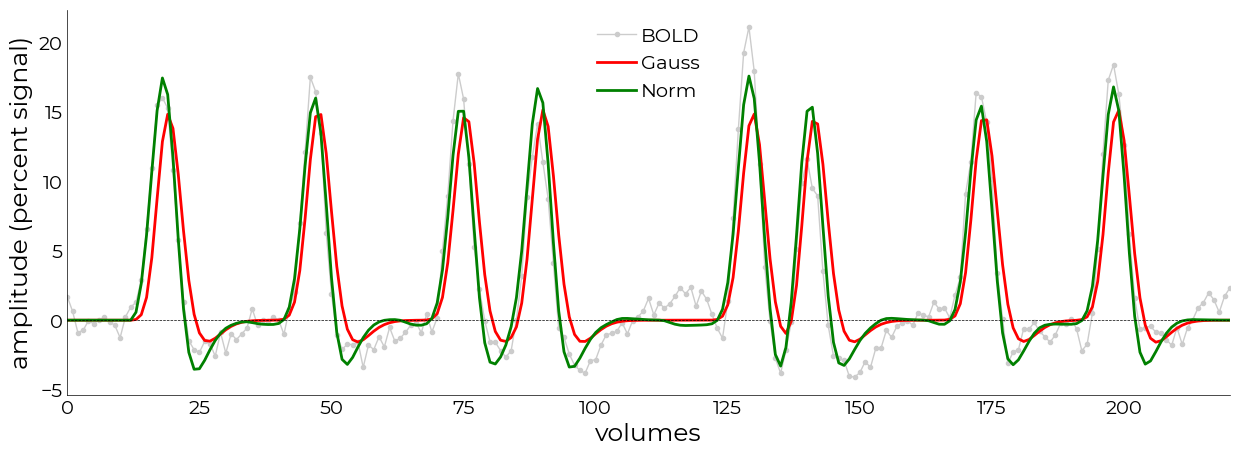

In [27]:
plotting.LazyLine(
    [data,pred1,pred2],                       # list of multiple 1D-arrays
    add_hline="default",                      # adds horizontal line at y=0
    color=["#cccccc", 'r', "g"],              # list of same length as data (RGB/hex/strings)
    line_width=[1,2,2],                       # list of same length as data
    markers=['.',None,None],                  # plot BOLD as connected dots, predictions as solid lines
    x_label="volumes",                        # x label
    y_label="amplitude (percent signal)",     # y label
    figsize=(15,5),                           # set figure size
    labels=['BOLD','Gauss','Norm']            # labels with the same length as data list
)

You can see that the normalization model is capturing different characteristics compared to the Gaussian model. Also note that the processing time was a lot longer compared to the Gaussian model. These are things to consider when selecting your model (for a few hundred voxels this is fine, but for >500000 it gets a bit complicated). You can speed this up by using `L-BGFS`-minimization over `trust-constr`-minimization. See doc of [pRFmodelFitting]()

Now let's look at saving and loading parameters. To save parameters, we need an output directory and the basename for the output. Some stuff will be appended depending on the stage, model, or whether the HRF was fitted as well.

In [18]:
# let's use the gaussian model because it's faster
gauss = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5, 
    model="gauss",
    stage="iter",
    verbose=True,
    fix_bold_baseline=True,
    write_files=True,                                   # set flag to write output
    output_dir=opj(opd(opd(prf.__file__)), 'examples'), # set custom output directory (defaults to current working directory)
    output_base="sub-01_ses-1"                          # set custom output basename; "_model-{model}_stage-{stage}_desc-prf_params.{pkl|npy}" is appended
    )

# fit
gauss.fit()

Reading settings from '/mnt/d/FSL/shared/spinoza/programs/packages/linescanning/misc/prf_analysis.yml'
Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
Starting gauss grid fit at 2022/10/18 11:27:25
Completed Gaussian gridfit at 2022/10/18 11:27:34. Voxels/vertices above 0.1: 1/1
Gridfit took 0:00:09.139608
Mean rsq>0.1: 0.53
Save grid-fit parameters in /mnt/d/FSL/shared/spinoza/programs/packages/linescanning/examples/sub-01_ses-1_model-gauss_stage-grid_desc-prf_params.pkl
Starting gauss iterfit at 2022/10/18 11:27:34
Completed gauss iterfit at 2022/10/18 11:27:44. Mean rsq>0.1: 0.53
Iterfit took 0:00:09.209858
Save iter-fit parameters in /mnt/d/FSL/shared/spinoza/programs/packages/linescanning/examples/sub-01_ses-1_model-gauss_stage-iter_desc-prf_params.pkl


We see that stuff is save now in our specified directory with the basename of our choice.

In [ ]:
os.listdir(opj(opd(prf.__file__), 'examples'))


['bold.mat',
 'design_task-2R.mat',
 'events.tsv',
 'figures',
 'prf.npy',
 'sub-01_ses-1_model-gauss_stage-grid_desc-prf_params.pkl',
 'sub-01_ses-1_model-gauss_stage-iter_desc-prf_params.pkl']

This pickle file has the settings, predictions, and parameters embedded in it. We can load this back in as follows:

In [20]:
# we initiate the model as per usual
gauss_load = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,
    verbose=True)

# decide which parameters you want to load. Here, let's load the parameters from the iterative Gaussian fit
load_pars = opj(opj(opd(opd(prf.__file__)), 'examples'), "sub-01_ses-1_model-gauss_stage-iter_desc-prf_params.pkl")

# We would then tell `gauss_load` to load this file in, and set the correct attributes internally. If there's no known settings, it will use the most recent settings file from the directory in which the to-be-loaded parameters live. If you specify a pickle file, these default settings will be overwritten by settings specified in the pickle-file
gauss_load.load_params(load_pars, model="gauss", stage="iter")

Reading settings from '/mnt/d/FSL/shared/spinoza/programs/packages/linescanning/misc/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0]
Reading settings from pickle-file (safest option; overwrites other settings)
Inserting parameters from <class 'str'> as 'gauss_iter' in <linescanning.prf.pRFmodelFitting object at 0x7fa8de225be0>


We can now make the same plot again, but from an independent object (now `gauss_load`, rather than `gauss`)

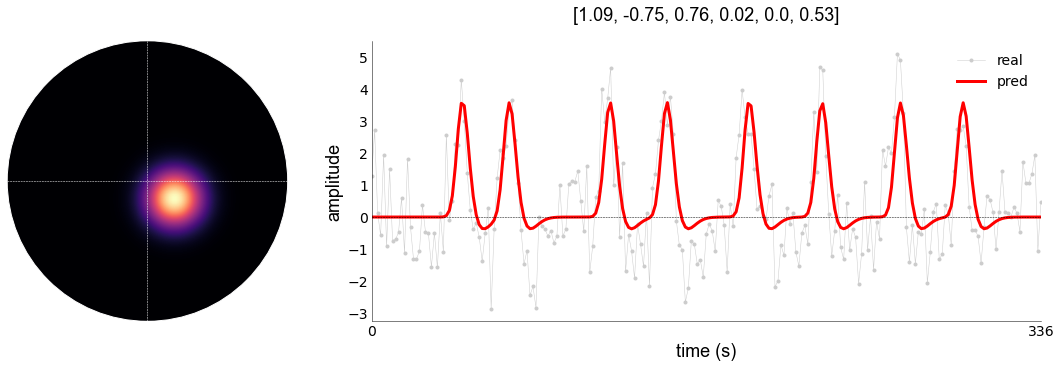

In [21]:
# plot the model fit
_, _, _, pred1 = gauss_load.plot_vox(vox_nr=0, title="pars")

If we try to plot the grid-parameters, that will fail. This is because `plot_vox` assumes you want the `iter`-parameters to be plotted, but we did not set that attribute inside `gauss_load`

In [22]:
_, _, _, _ = gauss_load.plot_vox(vox_nr=0, title='pars', stage="grid")


ValueError: Could not find grid parameters for gauss

It will also fail if we try to plot a model other than the one we specified (in our case, `gauss`), because we told the object to load in the parameters as `gauss`.

In [23]:
_, _, _, _ = gauss_load.plot_vox(vox_nr=0, title='pars', stage="iter", model="norm")


ValueError: Could not find iter parameters for norm

We can also plot the HRFs

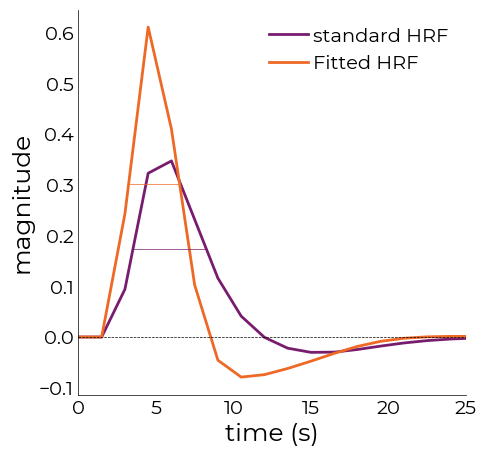

In [44]:
from lazyfmri import fitting

# HRF is now created inside the object (a new feature of pRFpy)
hrf_can = gauss.gauss_model.create_hrf([1, 1, 0], "SPM", False)

# select HRF parameters and add 1 for first basis set
hrf = list(norm.norm_iter[:,-3:-1].squeeze())
hrf.insert(0,1)
hrf_fit = gauss.gauss_model.create_hrf(hrf, "SPM", False)

pl = plotting.LazyLine(
    [hrf_can, hrf_fit],
    labels=["standard HRF","Fitted HRF"],
    xx=np.arange(0,40,gauss.TR),
    figsize=(5,5),
    line_width=2,
    x_lim=[0,25],
    add_hline='default',
    cmap='inferno',
    x_label="time (s)",
    y_label="magnitude"
)

# get fwhm
colors = sns.color_palette('inferno', len(pl.array))
fwhm_objs = []
for hrf in pl.array:
    fwhm_objs.append(
        fitting.FWHM(
            np.arange(0,40,gauss.TR),
            hrf.squeeze()
        )
    )

# heights need to be adjusted for by axis length 
xlim = pl.axs.get_xlim()
tot = sum(list(np.abs(xlim)))
for ix, ii in enumerate(fwhm_objs):
    start = (ii.t0_-xlim[0])/tot
    pl.axs.axhline(
        ii.half_max,
        xmin=start,
        xmax=start+ii.fwhm/tot,
        color=colors[ix],
        linewidth=0.5
    )

We can see that the `fitted HRF` is faster than the standard HRF; something would expect from 7T data